# Importing Dependencies

In [1]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Datasets

In [3]:
train_dir = 'imgdata_v2/split_dataset/train_aug/'
test_dir = 'imgdata_v2/split_dataset/test/'
val_dir = 'imgdata_v2/split_dataset/val/'

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(256, 256))
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(256, 256))

Found 7051 files belonging to 2 classes.
Found 415 files belonging to 2 classes.


# Scaling Dataset

In [5]:
train_dataset.as_numpy_iterator().next()[0][0].max()

255.0

In [6]:
train_data = train_dataset.map(lambda x, y: (x/255, y))

In [7]:
train_data.as_numpy_iterator().next()[0][0].max()

0.9970588

In [8]:
val_data = val_dataset.map(lambda x, y: (x/255, y))

# GoogLeNet Model

In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import concatenate

In [10]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)
  output_layer = concatenate([path1, path2, path3, path4], axis = -1)
  return output_layer

In [11]:
def GoogLeNet():
    input_layer = Input(shape = (256, 256, 3))
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(1, activation = 'sigmoid')(X1)
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(5, activation = 'sigmoid')(X2)
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)
    X = GlobalAveragePooling2D(name = 'GAPL')(X)
    X = Dropout(0.4)(X)
    X = Dense(1, activation = 'sigmoid')(X)
    model = Model(input_layer, [X, X1], name = 'GoogLeNet')

    return model

In [12]:
call_model = GoogLeNet();
call_model.compile(optimizer = tf.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy']);
call_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 125, 125, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 62, 62, 64)   0           ['conv2d[0][0]']                 
                                                                                          

In [13]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [14]:
model_fit = call_model.fit(train_data, 
                      epochs=5, 
                      shuffle=True, 
                      validation_data=val_data, 
                      # callbacks=[tfb_callback]
                           )

Epoch 1/5
221/221 [==============================] - 42s 140ms/step - loss: 1.3841 - dense_4_loss: 0.6934 - dense_1_loss: 0.6907 - dense_4_accuracy: 0.5107 - dense_1_accuracy: 0.5365 - val_loss: 1.3692 - val_dense_4_loss: 0.6922 - val_dense_1_loss: 0.6770 - val_dense_4_accuracy: 0.5157 - val_dense_1_accuracy: 0.5831
Epoch 2/5
221/221 [==============================] - 28s 125ms/step - loss: 1.1499 - dense_4_loss: 0.6327 - dense_1_loss: 0.5172 - dense_4_accuracy: 0.6158 - dense_1_accuracy: 0.7378 - val_loss: 0.7417 - val_dense_4_loss: 0.4386 - val_dense_1_loss: 0.3031 - val_dense_4_accuracy: 0.8289 - val_dense_1_accuracy: 0.8458
Epoch 3/5
221/221 [==============================] - 28s 125ms/step - loss: 0.5679 - dense_4_loss: 0.3395 - dense_1_loss: 0.2284 - dense_4_accuracy: 0.8658 - dense_1_accuracy: 0.8999 - val_loss: 0.4811 - val_dense_4_loss: 0.2789 - val_dense_1_loss: 0.2022 - val_dense_4_accuracy: 0.8458 - val_dense_1_accuracy: 0.9133
Epoch 4/5
221/221 [===========================

## Model Performance 

Text(0.5, 0.98, 'GoogLeNet Performance Curves')

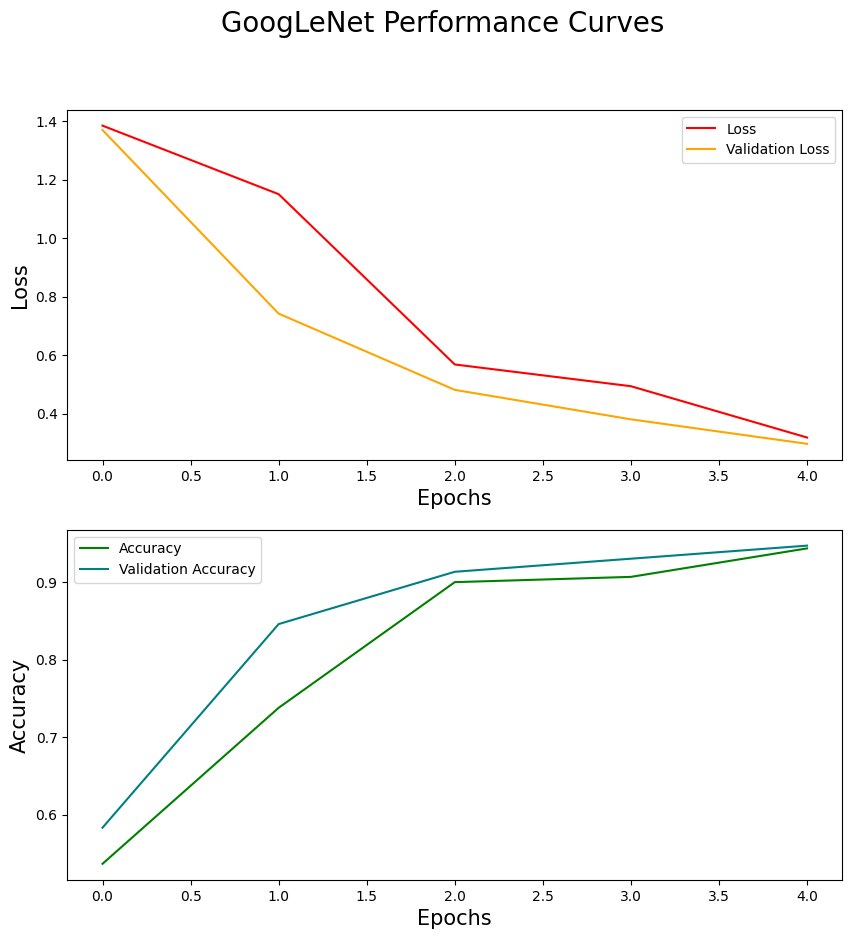

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epochs', fontsize=15)
axs[0].set_ylabel('Loss', fontsize=15)


axs[1].plot(model_fit.history['dense_1_accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_dense_1_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Epochs', fontsize=15)
axs[1].set_ylabel('Accuracy', fontsize=15)

fig.suptitle('GoogLeNet Performance Curves', fontsize=20)

## Exporting Model

In [21]:
from keras.models import save_model, load_model

call_model.save(os.path.join('models_Reboot/','GoogLeNet_Re.h5'))

In [22]:
Model = load_model(os.path.join('models_Reboot/','GoogLeNet_Re.h5'))

In [23]:
Model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 125, 125, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 62, 62, 64)   0           ['conv2d[0][0]']                 
                                                                                          

## Evaluating Model

In [37]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(256, 256))

Found 210 files belonging to 2 classes.


In [38]:
test_data = test_dataset.map(lambda x, y : (x/255, y))

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()

In [51]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = Model.predict(X)
    y_pred = Model.predict(X)
    y_pred = tf.squeeze(y_pred, axis=-1)
    
    acc.update_state(y, y_pred)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)

1/1 [==============================] - 0s 38ms/step


ValueError: Shapes (2, 32) and (32,) are incompatible

In [47]:
accuracy = acc.result().numpy()
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', round(accuracy,5))
print('Precision\t:', round(precision,5))
print('Recall\t\t:', round(recall,5))
print('F1\t\t:', round(f1,5))

Accuracy	: 0.51322
Precision	: 0.0
Recall		: 0.0
F1		: nan


C:\Users\joshu\AppData\Local\Temp\ipykernel_19996\1049911424.py:4: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision*recall) / (precision+recall)


1/1 [==============================] - 0s 31ms/step


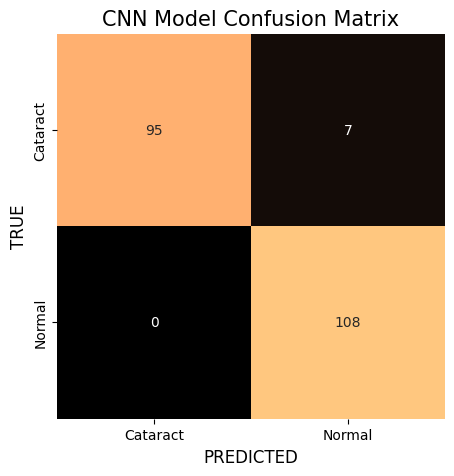

In [92]:
Y=[]
Y_pred=[]
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = Model.predict(X)
    y_pred = (y_pred > 0.5)
    Y.extend(y)
    Y_pred.extend(y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, Y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='copper', cbar=False,
            xticklabels=['Cataract', 'Normal'], yticklabels=['Cataract', 'Normal'])
plt.xlabel('PREDICTED', fontsize=12)
plt.ylabel('TRUE', fontsize=12)
plt.title('CNN Model Confusion Matrix', fontsize=15)
plt.show()